In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-02 17:34:06.015831: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 17:34:06.021738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-02 17:34:06.021799: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#preprocessing for efficient net

IMG_SIZE = 224
BATCH_SIZE = 32

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Paths to train, val, and test directories
train_dir = "chest_xray/train"
val_dir = "chest_xray/validation"
test_dir = "chest_xray/test"

# Load each set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4694 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


In [3]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Get a batch of images and labels
# image_batch, label_batch = next(train_generator)

# # Number of images to display
# num_images = 10

# # Iterate over the batch and plot each image

# fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# for i in range(num_images):
#     row = i // 5
#     col = i % 5
#     axes[row, col].imshow(image_batch[i])
#     axes[row, col].axis('off')
    
#     # Display label (0 or 1), where 0 might indicate 'Normal' and 1 'Pneumonia'
#     label = label_batch[i]
#     class_name = 'Normal' if label == 0 else 'Pneumonia'
#     axes[row, col].set_title(class_name, color='red')

# plt.tight_layout()
# plt.show()

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define the model
def create_resnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=1):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers (so they won't be trained)
    base_model.trainable = False
    
    # Add custom layers on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid')  # Use sigmoid for binary classification
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = create_resnet_model()

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with the data generators
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc}")

Epoch 1/10
147/147 [==============================] - 91s 610ms/step - loss: 0.6144 - accuracy: 0.7098 - val_loss: 0.5428 - val_accuracy: 0.7299
Epoch 2/10
147/147 [==============================] - 93s 633ms/step - loss: 0.5326 - accuracy: 0.7409 - val_loss: 0.5091 - val_accuracy: 0.7231
Epoch 3/10
147/147 [==============================] - 95s 643ms/step - loss: 0.5151 - accuracy: 0.7448 - val_loss: 0.4970 - val_accuracy: 0.7709
Epoch 4/10
147/147 [==============================] - 93s 628ms/step - loss: 0.4960 - accuracy: 0.7501 - val_loss: 0.4923 - val_accuracy: 0.7726
Epoch 5/10
147/147 [==============================] - 92s 622ms/step - loss: 0.4825 - accuracy: 0.7533 - val_loss: 0.4722 - val_accuracy: 0.7214
Epoch 6/10
147/147 [==============================] - 94s 635ms/step - loss: 0.4843 - accuracy: 0.7563 - val_loss: 0.4605 - val_accuracy: 0.7675
Epoch 7/10
147/147 [==============================] - 93s 633ms/step - loss: 0.4704 - accuracy: 0.7616 - val_loss: 0.4812 - val_ac

1/1 [==============================] - 0s 389ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.31      0.47       159
         1.0       0.80      1.00      0.88       427

    accuracy                           0.81       586
   macro avg       0.88      0.65      0.68       586
weighted avg       0.84      0.81      0.77       586



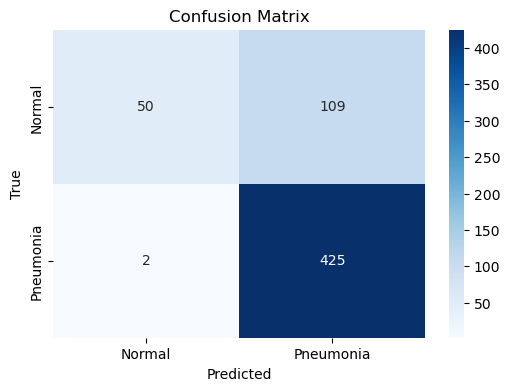

In [5]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store predictions and true labels
all_true_labels = []
all_predicted_classes = []

# Loop through the test set
for img_batch, label_batch in test_generator:
    # Make predictions for the current batch
    predictions = model.predict(img_batch)
    
    # Convert predictions to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype("int32")
    
    # Append the true labels and predicted labels to the lists
    all_true_labels.extend(label_batch)
    all_predicted_classes.extend(predicted_classes)

    # Break the loop if we have processed the entire test set (optional: to prevent infinite loop)
    if len(all_true_labels) >= len(test_generator.classes):
        break

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_classes = np.array(all_predicted_classes)

# Generate the classification report
print(classification_report(all_true_labels, all_predicted_classes))

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_classes)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 28ms/step


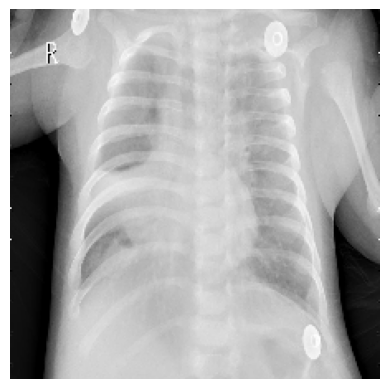

Prediction: Pneumonia


In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Function to predict and display image with the prediction
def predict_and_display_image(image_path, model, img_size=IMG_SIZE):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_size, img_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Rescale to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make the prediction
    prediction = model.predict(img_array)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
    
    # Return prediction result
    return "Pneumonia" if prediction > 0.5 else "Normal"

# Example image from the test set (replace with your image path)
image_path = "/home/eas/DLProject/chest_xray/validation/PNEUMONIA/person1389_bacteria_3531.jpeg"  # Update with your actual image path

# Call the function to make the prediction and display the image
result = predict_and_display_image(image_path, model)
print(f"Prediction: {result}")
